In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'cat_dog_data_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [4]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# validation data shouldn't be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50
)

Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 50s 498ms/step - loss: 0.5509 - acc: 0.7220 - val_loss: 0.4343 - val_acc: 0.8120
Epoch 2/20
100/100 [==============================] - 53s 531ms/step - loss: 0.3755 - acc: 0.8430 - val_loss: 0.3245 - val_acc: 0.8760
Epoch 3/20
100/100 [==============================] - 53s 527ms/step - loss: 0.3159 - acc: 0.8620 - val_loss: 0.3309 - val_acc: 0.8550
Epoch 4/20
100/100 [==============================] - 52s 525ms/step - loss: 0.2895 - acc: 0.8735 - val_loss: 0.2767 - val_acc: 0.8830
Epoch 5/20
100/100 [==============================] - 53s 529ms/step - loss: 0.2676 - acc: 0.8855 - val_loss: 0.2756 - val_acc: 0.8810
Epoch 6/20
100/100 [==============================] - 53s 528ms/step - loss: 0.2551 - acc: 0.8850 - val_loss: 0.2597 - val_acc: 0.8910
Epoch 7/20
100/100 [==============================] - 53s 528ms/step - loss: 0.2262 - acc: 0.9050 - val_loss: 0.2470 - val_acc: 0.8890
Epoch 8/20
1

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


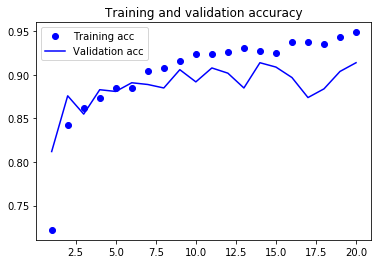

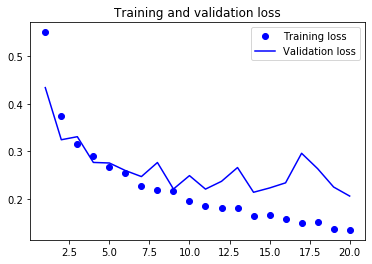

In [9]:
import matplotlib.pyplot as plt

print(history.history.keys())

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

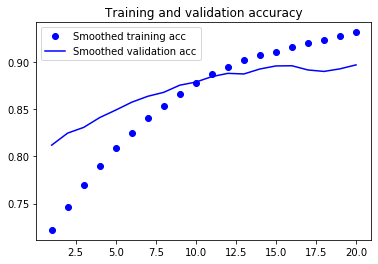

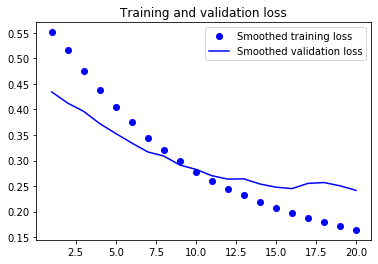

In [11]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()